by Hyun Gu Kang

# Coursera/IBM Data Science Professional Certificate - Capstone Project
# Relocation Neighborhood Adviser Project

### Week 4/ Week 5 Assignment

## Project Description


As a newly minted data scientist, I will likely need to relocate.  Where should I move to in the US?  (I'd like to do this for the rest of the world, but not sure about data sources yet)
This problem affects many future data scientists, and therefore the target audience are fellow future data scientists looking to relocate to a neighborhood.  To make the problem tractable and easier to manage, this will be done only for Texas.  

I will create a neighborhood desirability dashboard(?) by using the following data:

- Neighborhood conveniences
- Neighborhood income 
- Location of Data Science venues nearby




Data Sources:
1.  Foursquare 
identify venue density - is this a quiet, slow area?
identify neighboring density - is it near a busy area?
identify if area has data science venues nearby

2.  US Tax Statistics 
https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2017-zip-code-data-soi
- merge in population density per zip code (postal code)
- merge in income level
- number of dependent exemptions - is this a neighborhood with kids/families?
- home mortgage interest paid - do people own homes here?

3.  Census 2010 Shapefile for each ZCTA/zip codes.

Current plans:
Features to be used:
1.  venue density locally
2.  income level
3.  likely presence of kids
4.  near "choir" venues
5.  near "organic" venues
6.  near to data science venues



  

Step 1.  Process Tax data

For now, use data from Texas

I will take the spreasheet  from the IRS
https://www.irs.gov/pub/irs-soi/17zp44tx.xlsx
    
    
into a dataframe that lists the following in each zip code

- merge in population density per zip code (postal code)
- merge in income level
- number of dependent exemptions - is this a neighborhood with kids/families?
- home mortgage interest paid - do people own homes here?


# Turn this into a code cell as necessary

!pip install GDAL
!pip install geopy
!pip install folium
!pip install plotly
!pip install uszipcode
!pip install pyarrow
!pip install pyshp

In [191]:
# import some libraries to start
import numpy as np
import pandas as pd
import requests
import json

import geopy
import matplotlib as plt
import sklearn 

import folium
import plotly

from uszipcode import SearchEngine

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import pyarrow as pa
import pyarrow.feather as feather
import time
import shapefile

# load in the zip code data from the IRS.  This excel file has been cleaned before being imported





In [76]:
    fn='C:\\Users\\hkang\\OneDrive - California State University San Marcos\\Jobs\\TexasIncome.xlsx'
    dir = 'C:\\Users\\hkang\\OneDrive - California State University San Marcos\\Jobs\\'
df_data_0 = pd.read_excel(fn)
df_data_0.head()

,ZIP,Groups,Number,dependents,AGI,mortage_deductions,child tax credit
0,0,Total,12341100.0,9243980.0,906383393.0,2197250.0,2066350.0
1,0,"$1 under $25,000",4534890.0,2640150.0,57950821.0,85300.0,158230.0
2,0,"$25,000 under $50,000",3002620.0,2408330.0,108824591.0,248910.0,773650.0
3,0,"$50,000 under $75,000",1638720.0,1271700.0,100437721.0,348680.0,479780.0
4,0,"$75,000 under $100,000",1009320.0,838720.0,87504669.0,325630.0,325900.0


In [77]:
# Get nearby venues function, modified from Coursera Course

In [78]:
# @hidden_cell

#FourSquare key
{
    "tags": [
        "remove_cell",
    ]
}

CLIENT_ID = 'VX5CGIPTE3LGJXXA5RRY0THHBHTRJ1X4J445MZ1CRO3JR4IF' # your Foursquare ID
CLIENT_SECRET = 'NLHMULQL5ASVCFHKBVJJGDWJQ1TWZOAL3O2BEBS3N5TU10JJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=1000

In [79]:
#get all venues in each neighborhood

def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            1000) #LIMIT=1000, but the API call limits to 100.  Sigh.  No easy way to get around this.
            
        # make the GET request

        results= None
        
        while results == None:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
            except:
                time.sleep(.1)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [86]:
#get specific venues in each neighborhood

def QueryVenues(names, latitudes, longitudes, radius, search_query):
    LIMIT=1000
    nearby_venues=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        #print('\r'+ str(name))
      
        print("Progress {:2.1%}".format((name-70000) / 10000), end="\r")


        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, rad, LIMIT)

    
    
        # make the GET request

        results= None
        
        while results == None:
            try:
                results = requests.get(url).json()["response"]['venues']
            except:
                time.sleep(.01)
            
                
        Count = pd.DataFrame(results).shape[0]

   
        nearby_venues.append({'Zip': name, search_query : Count })

    
    nearby_venues = pd.DataFrame(nearby_venues)
    
    return(nearby_venues)

In [ ]:
# Clean the dataframe into a new dataframe with a list of zip codes
areas=pd.DataFrame(columns=['Zip','population','kids','income_mean','income_median','home','longitude', 'latitude', 'pop density', 'radius', 'area'])



for chunks in range(8,12960,8):

    df = df_data_0.iloc[chunks:chunks+7,]    
    
     
    
    Zip = int(df.iloc[0,0])  # get the zip code of the data section
    population = int(df.iloc[0,2])
    kids = df.iloc[0,3]/population   #proportion with dependents
    income_mean = round(df.iloc[0,4]/population*1000 )
    home = df.iloc[0,5]/population   #proportion of househholds claiming primary home
    middle= round(population/2)
    
    incomegroups=[12500, 37500, 62500, 87500, 150000, 300000]
    breakgroups=[25000,50000,75000,100000,200000]
    
    for X in range(1,6):
        
        middle = middle - df.iloc[X,2]
        if middle < 0:
            income_median=incomegroups[X-1]
            break
        if middle == 0:
            income_median=breakgroups[X-1]
            break
    
     #merge in zip code data using USZipCodes package
    search = SearchEngine(simple_zipcode=True)
    zipinfo = search.by_zipcode(str(Zip))
    area=zipinfo.land_area_in_sqmi
    lat = zipinfo.lat
    long = zipinfo.lng
    radius=zipinfo.radius_in_miles
    units=zipinfo.housing_units
    density=zipinfo.population_density
    
    
    
    
    areas = areas.append(pd.Series([Zip, population, kids, income_mean, income_median, home, long, lat, density, radius, area], index=areas.columns ), ignore_index=True)

In [217]:
areas.shape

(1619, 11)

## Here is the merged data that shows various features of the neighborhoods from Zip and IRS data

In [216]:
areas.head(30)

,Zip,population,kids,income_mean,income_median,home,longitude,latitude,pop density,radius,area
0,75001.0,9340.0,0.299786,98719.0,37500.0,0.129550,-96.84,32.96,3237.0,2.0,3.83
1,75002.0,30620.0,0.795232,96885.0,62500.0,0.335075,-96.61,33.08,1699.0,5.0,37.16
2,75006.0,23870.0,0.662338,54059.0,37500.0,0.144533,-96.89,32.95,2746.0,4.0,16.89
3,75007.0,26370.0,0.604854,71146.0,37500.0,0.241183,-96.90,33.00,4433.0,4.0,11.65
4,75009.0,6710.0,1.023845,113386.0,87500.0,0.451565,-96.80,33.30,92.0,9.0,95.42
5,75010.0,14470.0,0.621977,84670.0,62500.0,0.275052,-96.90,33.03,2678.0,3.0,8.07
6,75013.0,19110.0,0.856096,139568.0,87500.0,0.422815,-96.69,33.12,2026.0,3.0,14.98
7,75019.0,20160.0,0.780258,145329.0,87500.0,0.354663,-96.98,32.96,2347.0,3.0,16.47
8,75020.0,10080.0,0.636905,54467.0,37500.0,0.104167,-96.60,33.76,350.0,6.0,62.57
9,75021.0,3880.0,0.587629,49901.0,37500.0,0.100515,-96.47,33.74,133.0,7.0,60.26


# Process Venues information
### For each zip, find venues within 1 km of the zip location.  Obviously, it does not cover the entire area cleanly, but it's what I can do to estimate venue density in the area.

In [ ]:
import time
venues1000 = getNearbyVenues(names=areas['Zip'],
                                   latitudes=areas['latitude'],
                                   longitudes=areas['longitude'],
                                  radius = areas['radius']*0+1609)  #convert to meters


## Next, identify all the nearby Data Sciences Venues using FourSquare

In [88]:
# data science venues within 100 km of the search location
data_venues = QueryVenues(names=areas['Zip'],
                                   latitudes=areas['latitude'],
                                   longitudes=areas['longitude'],
                                  radius = areas['radius']*0+100000, search_query = 'data science')  #convert to meters


Next, identify all the nearby personal preference venues:

In [89]:
# organic venues
organic_venues = QueryVenues(names=areas['Zip'],
                                   latitudes=areas['latitude'],
                                   longitudes=areas['longitude'],
                                  radius = areas['radius']*0+10000, search_query = 'organic')  #convert to meters

In [90]:
choir_venues = QueryVenues(names=areas['Zip'],
                                   latitudes=areas['latitude'],
                                   longitudes=areas['longitude'],
                                  radius = areas['radius']*0+10000, search_query = 'choir')  #convert to meters

In [218]:
choir_venues.head()

,Zip,choir
0,75001.0,8
1,75002.0,2
2,75006.0,5
3,75007.0,5
4,75009.0,0


In [219]:
data_venues.head()

,Zip,data science
0,75001.0,50
1,75002.0,50
2,75006.0,50
3,75007.0,50
4,75009.0,50


### scratch code

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, 32.96, -96.84, VERSION, 'data science', 100000, LIMIT)
results = requests.get(url).json()["response"]['venues']
pd.DataFrame(results).shape[0]

#speed up life through saving these files.  Note that these libraries don't work in IBM Watson Studio once the kernel is off.  Where does it save?????


dir = 'C:\\Users\\hkang\\OneDrive - California State University San Marcos\\Jobs\\'
feather.write_feather(areas, dir+ 'areas_saved')
#feather.write_feather(venues,['venues_saved')
feather.write_feather(venues1000, dir+'venues1000_saved')




In [ ]:
dir = 'C:\\Users\\hkang\\OneDrive - California State University San Marcos\\Jobs\\'
areas = feather.read_feather(dir+ 'areas_saved')
venues1000 = feather.read_feather(dir+"venues1000_saved")

In [91]:
venues1000.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,75001.0,32.96,-96.84,La Spiga,32.958278,-96.837417,Bakery
1,75001.0,32.96,-96.84,Cindi's N.Y. Delicatessen,32.961864,-96.838873,Diner
2,75001.0,32.96,-96.84,Best Thai Signature,32.954790,-96.841320,Thai Restaurant
3,75001.0,32.96,-96.84,Elite Cigar Cafe,32.954967,-96.837875,Smoke Shop
4,75001.0,32.96,-96.84,Anime Pop,32.954681,-96.841196,Hobby Shop


In [92]:
venue1k=venues1000.groupby('Neighborhood').count()
#feather.write_feather(venue1k, 'venue1000_saved')

In [93]:
venue1k.head(10)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
75001.0,100,100,100,100,100,100
75002.0,13,13,13,13,13,13
75006.0,53,53,53,53,53,53
75007.0,67,67,67,67,67,67
75009.0,2,2,2,2,2,2
75010.0,36,36,36,36,36,36
75013.0,14,14,14,14,14,14
75019.0,33,33,33,33,33,33
75020.0,25,25,25,25,25,25


In [94]:
# Merge in venue density.  Not the best way to identify venue density, but it is close enough for now

#rename venue1k
venue1k.reset_index(inplace=True)
venue1k.rename(columns={"Neighborhood": "Zip"}, inplace=True)
venue1k = venue1k.astype({"Zip": int})
venue1k = venue1k[['Zip','Venue']]                        

result = pd.merge(areas, venue1k, on=['Zip'])
result = pd.merge(result, data_venues, on=['Zip'])
result = pd.merge(result, organic_venues, on=['Zip'])
result = pd.merge(result, choir_venues, on=['Zip'])
result.head()

,Zip,population,kids,income_mean,income_median,home,longitude,latitude,pop density,radius,area,Venue,data science,organic,choir
0,75001.0,9340.0,0.299786,98719.0,37500.0,0.129550,-96.84,32.96,3237.0,2.0,3.83,100,50,8,8
1,75002.0,30620.0,0.795232,96885.0,62500.0,0.335075,-96.61,33.08,1699.0,5.0,37.16,13,50,5,2
2,75006.0,23870.0,0.662338,54059.0,37500.0,0.144533,-96.89,32.95,2746.0,4.0,16.89,53,50,9,5
3,75007.0,26370.0,0.604854,71146.0,37500.0,0.241183,-96.90,33.00,4433.0,4.0,11.65,67,50,6,5
4,75009.0,6710.0,1.023845,113386.0,87500.0,0.451565,-96.80,33.30,92.0,9.0,95.42,2,50,2,0


In [95]:
# drop unnecessary features for clustering

Data = result.drop(columns=['Zip','population', 'income_mean', 'longitude', 'latitude', 'radius'])
Data.head()

,kids,income_median,home,pop density,area,Venue,data science,organic,choir
0,0.299786,37500.0,0.129550,3237.0,3.83,100,50,8,8
1,0.795232,62500.0,0.335075,1699.0,37.16,13,50,5,2
2,0.662338,37500.0,0.144533,2746.0,16.89,53,50,9,5
3,0.604854,37500.0,0.241183,4433.0,11.65,67,50,6,5
4,1.023845,87500.0,0.451565,92.0,95.42,2,50,2,0


In [96]:
# Now cluster neighborhoods
# first, scale features
from sklearn.preprocessing import StandardScaler
# Initialise the Scaler 
Datascaled = StandardScaler().fit_transform(Data) 


In [97]:
Datascaled


array([[-2.29256627, -0.23375992, -0.28477439, ...,  0.4382477 ,
         0.70629724,  2.29490959],
       [ 0.36265462,  0.89020083,  1.55913562, ...,  0.4382477 ,
         0.23082381,  0.02892743],
       [-0.34955919, -0.23375992, -0.15035507, ...,  0.4382477 ,
         0.86478839,  1.16191851],
       ...,
       [ 0.90373504, -0.23375992,  0.2991619 , ...,  0.4382477 ,
        -0.56163192, -0.34873626],
       [-0.28860112, -0.23375992, -0.36856089, ...,  0.4382477 ,
        -0.24464963,  0.02892743],
       [ 0.18702079, -0.23375992, -0.21561573, ...,  0.4382477 ,
        -0.40314078,  0.02892743]])

In [202]:
Data.corr()

,kids,income_median,home,pop density,area,Venue,data science,organic,choir
kids,1.000000,-0.174438,-0.132270,-0.138634,0.003333,-0.393811,-0.067740,-0.306344,-0.107228
income_median,-0.174438,1.000000,0.783091,-0.067679,-0.050867,0.095760,0.131913,0.172305,0.109721
home,-0.132270,0.783091,1.000000,-0.089031,-0.115141,0.026223,0.247146,0.081825,0.114860
pop density,-0.138634,-0.067679,-0.089031,1.000000,-0.405301,0.698830,0.193007,0.632719,0.499968
area,0.003333,-0.050867,-0.115141,-0.405301,1.000000,-0.321931,-0.267357,-0.260297,-0.311927
Venue,-0.393811,0.095760,0.026223,0.698830,-0.321931,1.000000,0.156257,0.612297,0.433876
data science,-0.067740,0.131913,0.247146,0.193007,-0.267357,0.156257,1.000000,0.231590,0.238479
organic,-0.306344,0.172305,0.081825,0.632719,-0.260297,0.612297,0.231590,1.000000,0.349659
choir,-0.107228,0.109721,0.114860,0.499968,-0.311927,0.433876,0.238479,0.349659,1.000000


### looking at the correlation matrix:
As expected, home ownership and income are correlated, and kids, venue density and population density are correlated.  Surprisingly, Data Science venue density is not strontly correlated to other metrics.

In [98]:
   
model = sklearn.cluster.KMeans(n_clusters=5,  n_init=20).fit(Datascaled)
labels = model.labels_ 
#labels

Add in cluster labels to the *results dataframe

In [99]:
result['cluster']=labels
#results.assign(Cluster = labels)
 #pd.DataFrame(labels)
#results.shape
result.head()

,Zip,population,kids,income_mean,income_median,home,longitude,latitude,pop density,radius,area,Venue,data science,organic,choir,cluster
0,75001.0,9340.0,0.299786,98719.0,37500.0,0.129550,-96.84,32.96,3237.0,2.0,3.83,100,50,8,8,0
1,75002.0,30620.0,0.795232,96885.0,62500.0,0.335075,-96.61,33.08,1699.0,5.0,37.16,13,50,5,2,4
2,75006.0,23870.0,0.662338,54059.0,37500.0,0.144533,-96.89,32.95,2746.0,4.0,16.89,53,50,9,5,2
3,75007.0,26370.0,0.604854,71146.0,37500.0,0.241183,-96.90,33.00,4433.0,4.0,11.65,67,50,6,5,2
4,75009.0,6710.0,1.023845,113386.0,87500.0,0.451565,-96.80,33.30,92.0,9.0,95.42,2,50,2,0,4


In [100]:
result.groupby('cluster').mean()

,Zip,population,kids,income_mean,income_median,home,longitude,latitude,pop density,radius,area,Venue,data science,organic,choir
cluster,,,,,,,,,,,,,,,
0,76831.048193,13312.289157,0.460053,157756.626506,56325.301205,0.194003,-96.575916,30.971880,5156.783133,2.032722,5.675301,83.036145,50.000000,19.180723,3.759036
1,77742.966102,5461.779661,0.746598,55758.711864,37288.135593,0.094813,-98.263737,31.754356,802.966102,8.893779,137.798051,11.296610,18.381356,0.203390,0.415254
2,76960.546559,15160.283401,0.768418,56365.056680,32236.842105,0.112034,-97.399514,31.136032,3637.578947,2.849466,9.868097,38.093117,49.214575,4.688259,4.161943
3,77133.194915,7302.429379,0.750335,55922.203390,35663.841808,0.133424,-97.136026,30.917876,468.279661,8.111357,90.528842,6.420904,48.211864,0.624294,0.406780
4,77180.028986,15590.507246,0.740640,121573.036232,75905.797101,0.358112,-97.069087,31.059000,1231.869565,5.610096,42.422899,16.833333,49.840580,2.434783,1.992754


In [101]:
result.groupby('cluster').count()

,Zip,population,kids,income_mean,income_median,home,longitude,latitude,pop density,radius,area,Venue,data science,organic,choir
cluster,,,,,,,,,,,,,,,
0,83,83,83,83,83,83,83,83,83,83,83,83,83,83,83
1,118,118,118,118,118,118,118,118,118,118,118,118,118,118,118
2,247,247,247,247,247,247,247,247,247,247,247,247,247,247,247
3,354,354,354,354,354,354,354,354,354,354,354,354,354,354,354
4,138,138,138,138,138,138,138,138,138,138,138,138,138,138,138


### We now have cluster results.  Now for my interpretations with n=5:

- Cluster 0:  lower income, lower home in the household, high density, high venue density, including data, organic, and choir: up and coming urban

- Cluster 1:  lower income, low density. - I call this suburban with kids
    
- Cluster 2:  higher income, lower kids, or home with high density - Yuppie neighborhood

- Cluster 3:  high income, lower venues density - The estates

- Cluster 4:  lower income, lower home, lower density or venues, and low data science - rural


Next, I give these a desirability score by rank ordering them according to my preferences:

- Cluster 0 [up and coming) -  score = 4   (affordable, has desireable venues)
- Cluster 1 (suburban)   -  score = 2       (lacks desireable venues)
- Cluster 2 (yuppie) - score = 3             (has desireable venues)
- Cluster 3 (estates) = score = 1            (too expensive, even with a data scientist income)
- Cluster 4 (rural) - score = 0              (lacks jobs)

In an interactive system, the user could be asked to rank these groupings to determine which best fit their preferences.  Coming up with clever cluster descriptions would remain at human hands, however.







In [102]:
# Merge in Desireability score:  
# to be lazy, I will simply convert cluster labels to desirability:

result['score']= 4 -result['cluster']
result.loc[result.cluster== 1, 'score'] = 2 
result.loc[result.cluster ==3, 'score'] = 1 
result.head()

,Zip,population,kids,income_mean,income_median,home,longitude,latitude,pop density,radius,area,Venue,data science,organic,choir,cluster,score
0,75001.0,9340.0,0.299786,98719.0,37500.0,0.129550,-96.84,32.96,3237.0,2.0,3.83,100,50,8,8,0,4
1,75002.0,30620.0,0.795232,96885.0,62500.0,0.335075,-96.61,33.08,1699.0,5.0,37.16,13,50,5,2,4,0
2,75006.0,23870.0,0.662338,54059.0,37500.0,0.144533,-96.89,32.95,2746.0,4.0,16.89,53,50,9,5,2,2
3,75007.0,26370.0,0.604854,71146.0,37500.0,0.241183,-96.90,33.00,4433.0,4.0,11.65,67,50,6,5,2,2
4,75009.0,6710.0,1.023845,113386.0,87500.0,0.451565,-96.80,33.30,92.0,9.0,95.42,2,50,2,0,4,0


In [103]:
#Now the I have the desireability score of kinds of neighborhoods, regress to find the best predicted neighborhoods


# Using Scikit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(Data, result['score'], test_size = 0.25, random_state = 42)

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);



# Here, finding the best fitting model over multiple models isn't too meaningful, since we don't have very good training material.  
# Use the forest's predict method on the test data

In [104]:
predictions = rf.predict(test_features)
sklearn.metrics.r2_score(test_labels, predictions)

0.8943384941580056

 we have a ~90% Rsq fit with our random forest regression model

In [105]:
predicted_score = rf.predict(Data)

In [106]:
result['rf prediction']=predicted_score
result.head()

,Zip,population,kids,income_mean,income_median,home,longitude,latitude,pop density,radius,area,Venue,data science,organic,choir,cluster,score,rf prediction
0,75001.0,9340.0,0.299786,98719.0,37500.0,0.129550,-96.84,32.96,3237.0,2.0,3.83,100,50,8,8,0,4,3.970
1,75002.0,30620.0,0.795232,96885.0,62500.0,0.335075,-96.61,33.08,1699.0,5.0,37.16,13,50,5,2,4,0,0.000
2,75006.0,23870.0,0.662338,54059.0,37500.0,0.144533,-96.89,32.95,2746.0,4.0,16.89,53,50,9,5,2,2,2.224
3,75007.0,26370.0,0.604854,71146.0,37500.0,0.241183,-96.90,33.00,4433.0,4.0,11.65,67,50,6,5,2,2,2.006
4,75009.0,6710.0,1.023845,113386.0,87500.0,0.451565,-96.80,33.30,92.0,9.0,95.42,2,50,2,0,4,0,0.000


# now, what are the top desirable neighborhoods?

In [107]:
result.sort_values(by='rf prediction', ascending=False, axis = 0).head(15) 


,Zip,population,kids,income_mean,income_median,home,longitude,latitude,pop density,radius,area,Venue,data science,organic,choir,cluster,score,rf prediction
108,75219.0,16950.0,0.219469,164082.0,62500.0,0.185251,-96.820,32.810,10108.0,1.000000,2.19,100,50,18,3,0,4,4.0
99,75209.0,7740.0,0.445736,242643.0,62500.0,0.295866,-96.830,32.840,3862.0,2.000000,3.53,99,50,20,3,0,4,4.0
441,77057.0,20110.0,0.459473,144784.0,37500.0,0.183491,-95.490,29.750,9198.0,2.000000,4.26,100,50,29,5,0,4,4.0
440,77056.0,12780.0,0.354460,408747.0,87500.0,0.228482,-95.470,29.750,5397.0,2.000000,3.46,100,50,32,5,0,4,4.0
431,77046.0,1380.0,0.311594,231915.0,87500.0,0.123188,-95.435,29.732,10239.0,0.454545,0.12,100,50,24,4,0,4,4.0
427,77042.0,19440.0,0.574588,84288.0,37500.0,0.116255,-95.560,29.740,5821.0,2.000000,6.25,100,50,19,2,0,4,4.0
807,78702.0,12610.0,0.383822,75836.0,37500.0,0.161776,-97.710,30.260,4268.0,2.000000,5.00,100,50,28,4,0,4,4.0
415,77030.0,5320.0,0.471805,180871.0,62500.0,0.229323,-95.410,29.710,4069.0,1.000000,2.52,100,50,23,3,0,4,4.0
412,77027.0,10320.0,0.291667,356353.0,62500.0,0.206395,-95.450,29.740,5007.0,1.000000,2.86,100,50,30,4,0,4,4.0
841,78751.0,8620.0,0.171694,73721.0,37500.0,0.154292,-97.720,30.310,6001.0,1.000000,2.40,100,50,30,3,0,4,4.0


In [108]:
#Where are these awesome neighborhoods?

#add city names
result=result.astype({'Zip': 'int32'})
search = SearchEngine(simple_zipcode=True)

#result.loc[ result['Zip']==77086, 'city']=search.by_zipcode(str(77086)).major_city

for local in result['Zip']:
    result.loc[ result['Zip']==local, 'city']=search.by_zipcode(str(local)).major_city

    
    
result[['Zip','city','rf prediction']].sort_values(by='rf prediction', ascending=False, axis = 0).head(15) 


,Zip,city,rf prediction
108,75219,Dallas,4.0
99,75209,Dallas,4.0
441,77057,Houston,4.0
440,77056,Houston,4.0
431,77046,Houston,4.0
427,77042,Houston,4.0
807,78702,Austin,4.0
415,77030,Houston,4.0
412,77027,Houston,4.0
841,78751,Austin,4.0


## Using Random Forest, Dallas and Houston are the best areas in general

## Try linear model

In [109]:
from sklearn.linear_model import LinearRegression
# Instantiate
lg = LinearRegression()

# Fit
lg.fit(train_features, train_labels)
# Evaluate fit
predictions = lg.predict(test_features)
sklearn.metrics.r2_score(test_labels, predictions)

0.7439661623395248

###  75% fit using linear regression.  Do we get similar neighborhoods?

In [223]:
predicted_score = lg.predict(Data)
result['lr prediction']=predicted_score


In [111]:
result.sort_values(by='lr prediction', ascending=False, axis = 0).head(15) 

,Zip,population,kids,income_mean,income_median,home,longitude,latitude,pop density,radius,area,Venue,data science,organic,choir,cluster,score,rf prediction,city,lr prediction
810,78705,6520.0,0.107362,61194.0,12500.0,0.073620,-97.740,30.290,14272.0,1.000000,2.20,100,50,28,4,0,4,3.842,Austin,5.461262
465,77081,17450.0,0.908883,41115.0,12500.0,0.027507,-95.480,29.710,15456.0,1.000000,3.10,84,50,27,4,0,4,3.566,Houston,4.970501
841,78751,8620.0,0.171694,73721.0,37500.0,0.154292,-97.720,30.310,6001.0,1.000000,2.40,100,50,30,3,0,4,4.000,Austin,4.745056
441,77057,20110.0,0.459473,144784.0,37500.0,0.183491,-95.490,29.750,9198.0,2.000000,4.26,100,50,29,5,0,4,4.000,Houston,4.709116
440,77056,12780.0,0.354460,408747.0,87500.0,0.228482,-95.470,29.750,5397.0,2.000000,3.46,100,50,32,5,0,4,4.000,Houston,4.506680
431,77046,1380.0,0.311594,231915.0,87500.0,0.123188,-95.435,29.732,10239.0,0.454545,0.12,100,50,24,4,0,4,4.000,Houston,4.506342
412,77027,10320.0,0.291667,356353.0,62500.0,0.206395,-95.450,29.740,5007.0,1.000000,2.86,100,50,30,4,0,4,4.000,Houston,4.455803
807,78702,12610.0,0.383822,75836.0,37500.0,0.161776,-97.710,30.260,4268.0,2.000000,5.00,100,50,28,4,0,4,4.000,Austin,4.397563
387,77002,5800.0,0.217241,406824.0,62500.0,0.158621,-95.370,29.750,8320.0,2.000000,2.02,100,50,23,5,0,4,4.000,Houston,4.368335
845,78756,4600.0,0.306522,114666.0,62500.0,0.260870,-97.740,30.320,4303.0,1.000000,1.67,100,50,31,4,0,4,4.000,Austin,4.327493


### linear regression produces different mix - Houston and Austin.


In [116]:
# save the work!

feather.write_feather(result, 'zipcoderesults')

In [184]:
# load the file to resume if necessary
result = feather.read_feather('zipcoderesults')

In [220]:
# here is the summary of the features and classification results
result.describe()


,Zip,population,kids,income_mean,income_median,home,longitude,latitude,pop density,radius,area,Venue,data science,organic,choir,cluster,score,rf prediction,lr prediction
count,940.000000,940.000000,940.000000,9.400000e+02,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000
mean,77144.571277,10883.563830,0.727563,7.464791e+04,42699.468085,0.161292,-97.287542,31.105692,1869.163830,5.922993,60.712989,23.648936,45.127660,3.543617,1.923404,2.368085,1.506383,1.501281,1.526757
std,1372.900313,8940.584148,0.186692,7.618679e+04,22254.610266,0.111521,2.247105,1.851812,2090.017724,4.662096,108.173755,28.467199,11.123696,6.312860,2.649268,1.143879,1.036584,0.977006,0.912741
min,75001.000000,100.000000,0.107362,2.208500e+04,12500.000000,0.000000,-106.610000,25.980000,1.000000,0.056818,0.120000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.621929
25%,76021.750000,3622.500000,0.621596,4.318925e+04,37500.000000,0.078975,-97.952500,29.720000,117.000000,3.000000,8.257500,2.750000,50.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.891196
50%,77085.500000,9275.000000,0.736538,5.659800e+04,37500.000000,0.133101,-97.060000,30.700000,1088.000000,4.000000,18.795000,10.000000,50.000000,1.000000,1.000000,3.000000,1.000000,1.144500,1.328157
75%,78244.250000,15432.500000,0.845778,7.700050e+04,37500.000000,0.225765,-95.600000,32.760000,3146.000000,8.000000,69.767500,36.000000,50.000000,4.000000,3.000000,3.000000,2.000000,2.000000,2.036335
max,79936.000000,53540.000000,1.814815,1.455423e+06,150000.000000,0.580475,-93.700000,36.445000,15456.000000,33.000000,1708.120000,100.000000,50.000000,32.000000,14.000000,4.000000,4.000000,4.000000,5.461262


# Choropleth Graphing

## data.gov source:  
TIGER/Line Shapefile, 2015, 2010 nation, U.S., 2010 Census 5-Digit ZIP Code Tabulation Area (ZCTA5) National

Shapefile will be used to create a geojson file to read into Folium library for interactive map making.  Note, this attempt was not successful, a mock up graph is presented.


In [185]:
sf = shapefile.Reader("C:\\Users\\hkang\\Downloads\\tl_2015_us_zcta510\\tl_2015_us_zcta510.shp")

In [186]:
sf.shapeType

5

In [187]:
fields = sf.fields[1:]
fields

[['ZCTA5CE10', 'C', 5, 0],
 ['GEOID10', 'C', 5, 0],
 ['CLASSFP10', 'C', 2, 0],
 ['MTFCC10', 'C', 5, 0],
 ['FUNCSTAT10', 'C', 1, 0],
 ['ALAND10', 'N', 14, 0],
 ['AWATER10', 'N', 14, 0],
 ['INTPTLAT10', 'C', 11, 0],
 ['INTPTLON10', 'C', 12, 0]]

In [179]:
# @hidden_cell
# scratch code
#reader = shapefile.Reader(fname)
#reader.fields[1]
#reader.shapeType
#shape_recs=reader.shapeRecords()[0]
#reader.__dict__
#shape_recs.__dict__
#reader.fields[1:]


# Read the Data.gov shapefile

In [192]:
# read the shapefile

shape_recs=sf.shapeRecords()   # this extracts the shape information from the file

#feather.write_feather(shape_recs, 'shape_recs')   #feather can't save this format.


{}

# Since I can't get folium to cooperate, I will draw a static map that is not interactive.   Sigh.

See appendix for the code I wrote to try to make this work, albeit unsuccessfully.  Also note that not all areas identified in the IRS database has a value in the shapefile.  These are shaded gray.

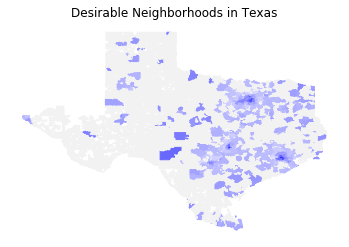

In [215]:


import matplotlib.patches as patches
import matplotlib.pyplot as plt

 
fig = plt.figure()
ax = fig.add_subplot(111)
 
for rec in shape_recs:
    points = rec.shape.points #shape
    d = rec.record  # record MetaData
    zip_code = int(d[1])
    if zip_code in range(75000,80000):
    
        #find matching 
        #print(zip_code)
        pred = result.loc[result['Zip']==zip_code, ['lr prediction']]
        
        c=(.95, .95, .95)  # there are many areas where data does not appear to be available.
        if pred.empty == False:
        
        #define color manually
            pred = pred.iloc[0,0]
            cval = 1-(pred+1)/7  
            c = (cval, cval, 1.0)  # blue-white scale
            #print (c)
    # You can also use a Named, Hex, Greyscale percent, or RGB value
    # c = 'blue'
    # c = '#0033CC'
    # c = '.75'
    # c = (0.0, 0.0, 1.0)
    
    
        patch = patches.Polygon(points,True,label=d[1],color=c)
        ax.add_patch(patch)
    
ax.autoscale()
plt.axis('off')
ax.title.set_text('Desirable Neighborhoods in Texas - using Linear Regression of Features')

Note that the three urban areas:  Dallas, Austin, and Hourston are showing up darker.  There are a few areas that are darker in west Texas, which is unexpected place we may need to look for jobs!  These areas include San Angelo and Rock Springs area.

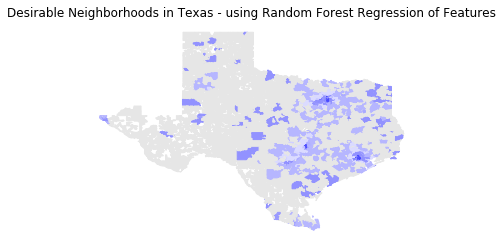

In [221]:
fig2 = plt.figure()
ax = fig2.add_subplot(111)
 
for rec in shape_recs:
    points = rec.shape.points #shape
    d = rec.record  # record MetaData
    zip_code = int(d[1])
    if zip_code in range(75000,80000):
    
        #find matching 
        #print(zip_code)
        pred = result.loc[result['Zip']==zip_code, ['rf prediction']]
        
        c=(.9, .9, .9)
        if pred.empty == False:
        
        #define color manually
            pred = pred.iloc[0,0]
            cval = 1-(pred+1)/7
            c = (cval, cval, 1.0)  # blue-white scale
            #print (c)
    # You can also use a Named, Hex, Greyscale percent, or RGB value
    # c = 'blue'
    # c = '#0033CC'
    # c = '.75'
    # c = (0.0, 0.0, 1.0)
    
    
        patch = patches.Polygon(points,True,label=d[1],color=c)
        ax.add_patch(patch)
    
ax.autoscale()
plt.axis('off')
ax.title.set_text('Desirable Neighborhoods in Texas - using Random Forest Regression of Features')

# Appendix

I tried to create an interactive folium map, but was not successful.  Here is the scratch code I tried to use.

In [ ]:
#parse shapefile into a geojson format

fields = sf.fields[1:]
field_names = [field[0] for field in fields]
buffer = []
for sr in shape_recs:
    d = sr.record  # record MetaData
    zip_code = d[1]
    if int(zip_code) in range(75000,80000):
        print(zip_code)
        atr = dict(zip(field_names, sr.record))
        geom = sr.shape.__dict__
        buffer.append(dict(type="Feature", \
        geometry=geom, properties=atr)) 

print('Buffer is done')

buffer[0]

In [ ]:
# try just printing to a file
!pip install geojson
import geojson
A=geojson.FeatureCollection(buffer)


In [ ]:
# geojson.dump doesn't work, so try just printing to file
geojsonfile = open("zcta.json", "w")
print(buffer, file=geojsonfile )
geojsonfile.close()
print('export is done')


In [ ]:
# create empty map zoomed in on Texas
map = folium.Map(location=[30, -100], zoom_start=5)
 
    
world_geo = 'zcta.json'

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = range(-1,6)
#threshold_scale = threshold_scale.tolist() # change the numpy array to a list
#threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# let Folium determine the scale.

folium.Choropleth(
    geo_data=world_geo,
    data=result,
    columns=['Zip', 'lr prediction'],
    key_on='feature.properties.ZCTA5CE10',
    threshold_scale=threshold_scale,
    fill_opacity=0.5, 
    line_opacity=0.2,
    fill_color='Greens',
    legend_name='Desirable Areas').add_to(map) 



# display the map of Texas
map

map.save('lineardata_map.html')